In [0]:
!pip install yfinance
!pip install matplotlib
!pip install pmdarima

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 529.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 15.9 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.5-cp310-cp310-linux_x86_64.whl size=727735 sha256=41ff398d0db30ef5e310e1690d860e34ccdf2c807ee0feb8d5e0800420bee4d4


In [0]:
DAYS_TO_PREDICT = 15

In [0]:
import yfinance as yf
import statsmodels.api as sm
import statsmodels.stats as sms
from scipy import stats, special
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

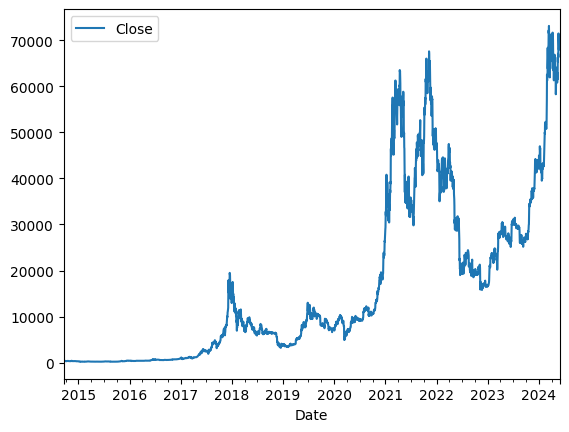

In [0]:
data = yf.download(tickers='BTC-USD', interval = '1D')

data[['Close']].plot()

In [0]:
len(data)

3542

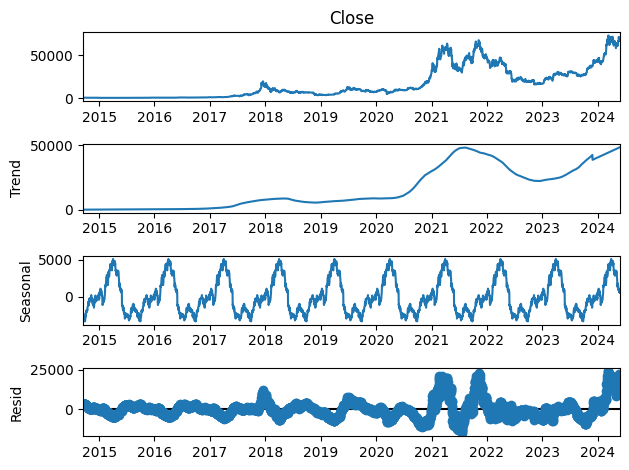

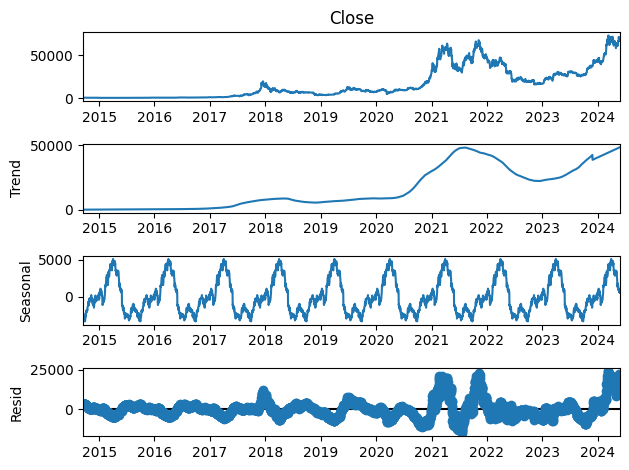

In [0]:
result_add = sm.tsa.seasonal_decompose(data['Close'], model = 'additive', period=365, extrapolate_trend = 'freq')
result_add.plot()

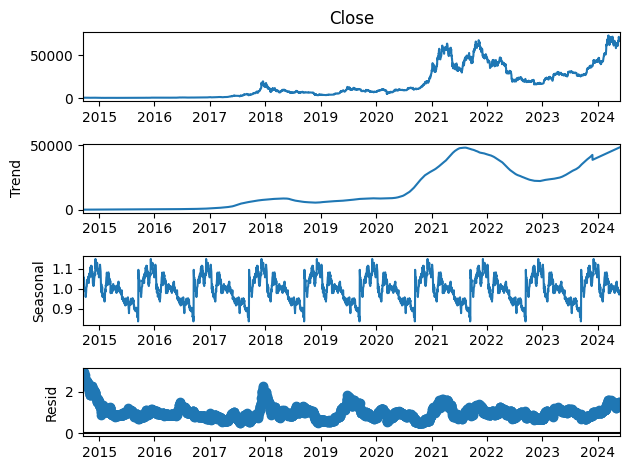

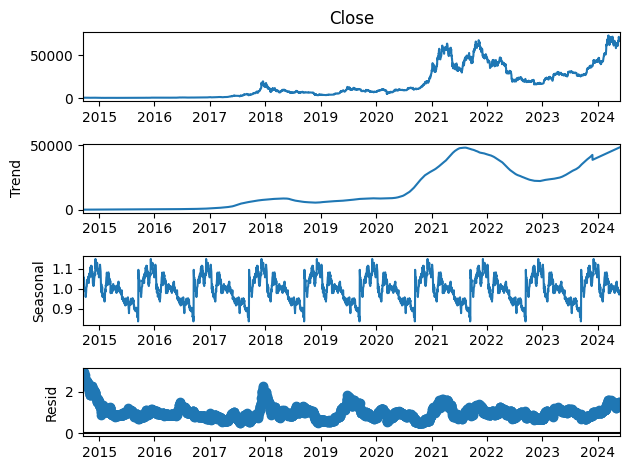

In [0]:
result_mul = sm.tsa.seasonal_decompose(data['Close'], model = 'multiplicative', period = 365, extrapolate_trend = 'freq')
result_mul.plot()

<Axes: xlabel='Date'>

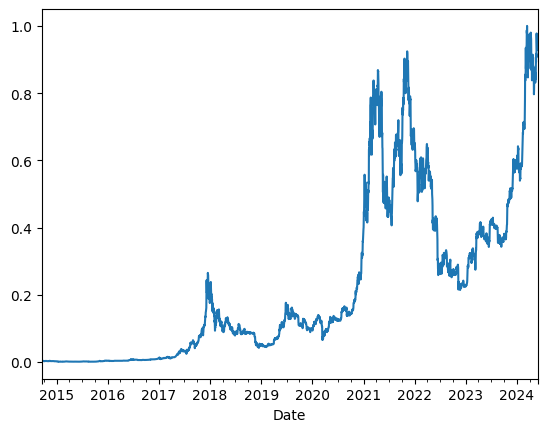

In [0]:
transform = MinMaxScaler(feature_range=(0,1))
data['Close-box'] = transform.fit_transform(data['Close'].values.reshape(-1,1))
data['Close-box'].plot()

In [0]:
cox_diff = pd.DataFrame(data['Close-box'])
cox_diff

,Close-box
Date,
2014-09-17,0.003830
2014-09-18,0.003379
2014-09-19,0.002972
2014-09-20,0.003166
2014-09-21,0.003027
...,...
2024-05-24,0.937489
2024-05-25,0.947637
2024-05-26,0.937379


In [0]:
cox_diff.dropna(inplace=True)

In [0]:
modelo_btc = sm.tsa.SARIMAX(
    data['Close-box'], order=(3, 0, 2), seasonal_order=(0, 0, 2, 7)
)
modelo_treinado_btc = modelo_btc.fit()

/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/databricks/python/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14891D+01    |proj g|=  9.30246D+03


 This problem is unconstrained.


  ys=-2.996E-02  -gs= 8.733E-01 BFGS update SKIPPED

At iterate    5    f= -1.31783D+00    |proj g|=  2.54464D+01

At iterate   10    f= -1.92887D+00    |proj g|=  9.54979D-01

At iterate   15    f= -2.21860D+00    |proj g|=  2.27053D+01

At iterate   20    f= -2.98209D+00    |proj g|=  1.39520D+01

At iterate   25    f= -3.01340D+00    |proj g|=  1.17593D-01

At iterate   30    f= -3.01640D+00    |proj g|=  1.26142D-01

At iterate   35    f= -3.01700D+00    |proj g|=  2.40981D+00

At iterate   40    f= -3.02559D+00    |proj g|=  2.22955D+00

At iterate   45    f= -3.02608D+00    |proj g|=  1.55589D-01

At iterate   50    f= -3.02609D+00    |proj g|=  1.57706D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

/databricks/python/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


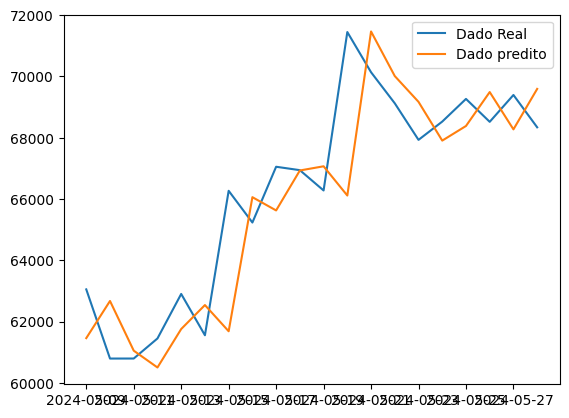

In [0]:
pred = transform.inverse_transform(modelo_treinado_btc.fittedvalues.values.reshape(-1,1))

plt.plot(data['Close'][-20:], label='Dado Real')
plt.plot(data.index[-20:], pred[-20:], label='Dado predito')
plt.legend()

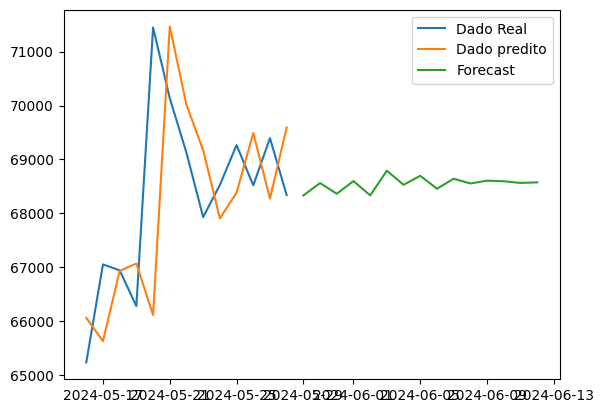

In [0]:
fc = modelo_treinado_btc.forecast(DAYS_TO_PREDICT)
forecast = transform.inverse_transform(fc.values.reshape(-1,1))
forecast = pd.DataFrame(forecast)
max_date = max(data.index.values)
start_date = pd.Timestamp(max_date) + pd.Timedelta(days=1)
calendar = pd.date_range(start=start_date, periods=DAYS_TO_PREDICT, freq="D")
forecast = forecast.set_index(calendar)
forecast
plt.plot(data["Close"][-13:], label='Dado Real')
plt.plot(data.index[-13:], pred[-13:], label='Dado predito')
plt.plot(forecast, label='Forecast')
plt.legend()